# Playing Hangman Game with High Success Rate Using Bidirectional LSTM

This notebook studies strategies playing Hangman with high successful rate (~ 60%) using bidirectional LSTM.

## Project Overview

In this project, we will:

1. **Frame the problem**: What is the hangman game?
2. **Explore the data**: Statistical analysis of the words
3. **Prepare the data**: Encoding the words for training
4. **Train Bidirectional LSTM models**: Model size is the key
5. **Develop the strategy**: Leveraging statistical approach and the bidirectional LSTM
6. **Playing the game**: Results and further improvements

---

## 1. Frame the Problem: What is Hangman Game?

### Game Rules
Hangman is a classic word-guessing game where players try to discover a hidden word by guessing individual letters:

1. **Setup**: A secret word is chosen and displayed as blank spaces (underscores)
2. **Guessing**: Players guess one letter at a time
3. **Correct Guess**: If the letter appears in the word, all instances are revealed
4. **Wrong Guess**: If the letter doesn't appear, it counts as a mistake
5. **Win Condition**: Player wins by revealing the entire word before making 6 wrong guesses
6. **Lose Condition**: Player loses after 6 wrong guesses

### Example Game (Win):
```
Secret word: "MACHINE"
Initial:     _ _ _ _ _ _ _

Guess 'E': (true)  → _ _ _ _ _ _ E
Guess 'A': (true)  → _ A _ _ _ _ E  
Guess 'T': (false)  → _ A _ _ _ _ E  (1/6 wrong)
Guess 'I': (true)  → _ A _ _ I _ E
Guess 'N': (true)  → _ A _ _ I N E
Guess 'M': (true)  → M A _ _ I N E
Guess 'C': (true)  → M A C _ I N E
Guess 'H': (true)  → M A C H I N E → Win
```


### Example Game (Loss):
```
Secret word: "APPLE"
Initial:     _ _ _ _ _

Guess 'E': (true)  → _ _ _ _ E
Guess 'I': (false)  → _ _ _ _ E  (1/6 wrong)
Guess 'T': (false)  → _ _ _ _ E  (2/6 wrong)
Guess 'H': (false)  → _ _ _ _ E  (3/6 wrong)
Guess 'P': (true)  → _ P P _ E
Guess 'J': (false)  → _ P P _ E  (4/6 wrong)
Guess 'C': (false)  → _ P P _ E  (5/6 wrong)
Guess 'S': (false)  → _ P P _ E  (6/6 wrong) -> Lose
```

In [1]:
# load the packages
import random
import string
import json
import collections
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import Sequence
from sklearn.model_selection import train_test_split
from itertools import combinations
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Bidirectional, Dropout, LayerNormalization, Add
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

c:\Users\yijin\anaconda3\envs\tf-gpu\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


## 2. Explore the Data: Statistical Analysis of the Words

As for almost all machine learning projects, it is often important to understand the data before building any model.

### Read data

In [2]:
# Data source: https://raw.githubusercontent.com/dwyl/english-words/master/words_alpha.txt
with open("words_public.txt", "r") as f:
    word_list = [line.strip().lower() for line in f if line.strip().isalpha() and len(line.strip()) >= 3]

print(f"Loaded {len(word_list)} words")
print(f"Sample words: {word_list[:10]}")
print(f"Word length range: {min(len(w) for w in word_list)} - {max(len(w) for w in word_list)}")

Loaded 369652 words
Sample words: ['aaa', 'aah', 'aahed', 'aahing', 'aahs', 'aal', 'aalii', 'aaliis', 'aals', 'aam']
Word length range: 3 - 31


In [3]:
# Before any data analysis, we split words into training and testing sets.
train_words, test_words = train_test_split(word_list, test_size=0.2, random_state=42)
print(f"Training words: {len(train_words)}")
print(f"Testing words: {len(test_words)}")

Training words: 295721
Testing words: 73931


In [4]:
# distribution of word_list
alphabet = string.ascii_lowercase

max_word_length = max(len(word) for word in train_words)
# initialize counts and word length counters
distribution = np.zeros((max_word_length, 26))
word_length_count = [0]*max_word_length

for word in word_list:
    word_len = len(word)
    word_length_count[word_len-1] += 1
    unique_letters = set(word)
    for letter in unique_letters:
        col = ord(letter) - ord('a')
        distribution[word_len - 1][col] += 1  # row index is word_len - 1

word_length_count = np.array(word_length_count)
word_length_count = word_length_count.reshape(-1,1)
distribution = np.divide(distribution, word_length_count)

C:\Users\yijin\AppData\Local\Temp\ipykernel_31920\1874556088.py:19: RuntimeWarning: invalid value encountered in divide
  distribution = np.divide(distribution, word_length_count)


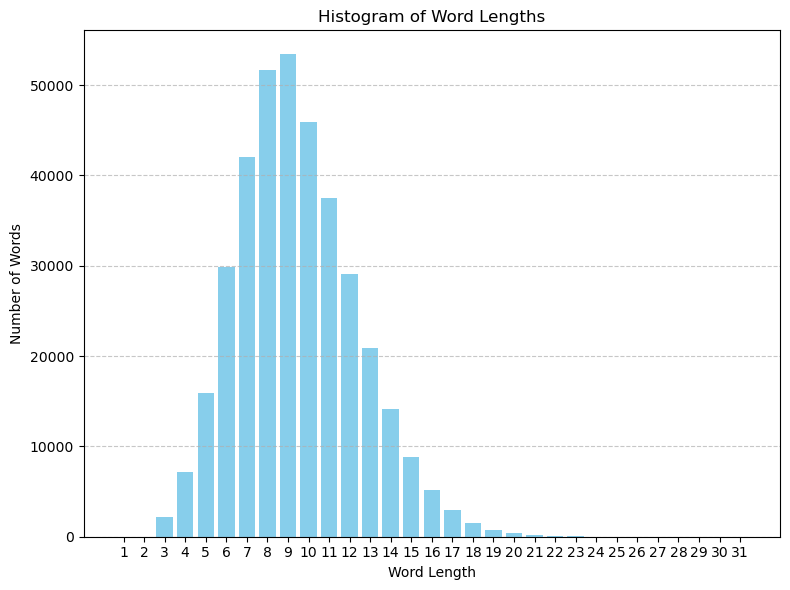

In [5]:
x = list(range(1, len(word_length_count) + 1))
plt.figure(figsize=(8, 6))
plt.bar(x, word_length_count.reshape(-1), color='skyblue')
plt.xlabel("Word Length")
plt.ylabel("Number of Words")
plt.title("Histogram of Word Lengths")
plt.xticks(x)  # Ensure each word length shows up on the x-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [6]:
print('maximum word length:', max_word_length)
print('proportion of words smaller than 20:', sum([1 for word in train_words if len(word) <= 20])/len(train_words) )

maximum word length: 31
proportion of words smaller than 20: 0.9991715163955215


The longest word is 31 letters long, but over 99.9% of the words are 20 letters or fewer. This suggests that we only need to focus on performing well for words of length 20 or less, and can reasonably ignore longer words.

We could also analyze the distribution of letters. In English, we would assume that certain letters appear more frequently in words than others. For instance, the probability that a word contains the letter 'e' is higher than that for the letter 'x'.

[]

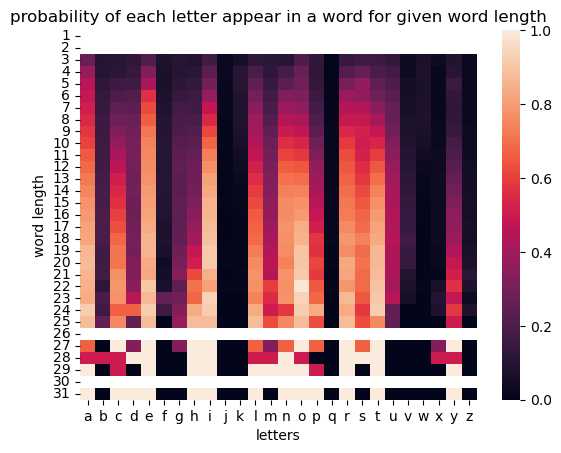

In [7]:
sns.heatmap(distribution, xticklabels=alphabet, yticklabels=range(1, max_word_length+1))
plt.xlabel('letters')
plt.ylabel('word length')
plt.title('probability of each letter appear in a word for given word length')
plt.plot()

We can see from the figure that certain letters like 'j', 'k', and 'v' appear very rarely, regardless of word length. In contrast, letters such as 'e' and 'i' occur frequently, and for words longer than 10 letters, we can be quite confident that they are present. 

We analyzed the probability of each word appears given each word. We can go even further, suppose we know a word is of length 5, and contains letter 'e', what is the most probable letter next? This
would require us to study the condition distribution of each letter given the word lengh 5 and the letter 'e'. 

In [8]:
# conditional probability of letters after screening out 
letter_to_idx = {letter: idx for idx, letter in enumerate(alphabet)}

def prob_screening(guessed_wrong_letters, guessed_correct_letters, word_length):
    guessed_wrong_set = set(guessed_wrong_letters)
    guessed_correct_letters = set(guessed_correct_letters)
    # Filter words: find all words that contain letters in guessed_correct_letters, but not contain letters in guessed_wrong_letters
    possible_words = [
        word for word in word_list
        if len(word) == word_length and guessed_wrong_set.isdisjoint(word) and guessed_correct_letters.issubset(word)
    ]
    # Initialize probability array
    prob = [0] * 26
    for word in possible_words:
        for letter in set(word):  # avoid double-counting letters
            if letter not in guessed_correct_letters:
                prob[letter_to_idx[letter]] += 1
    n = len(possible_words) or 1  # avoid division by zero
    prob = [p / n for p in prob]
    return possible_words, prob

In [9]:
_, conditional_prob = prob_screening(guessed_wrong_letters = [], guessed_correct_letters = ['e'], word_length = 5)
_, un_conditional_prob = prob_screening(guessed_wrong_letters = [], guessed_correct_letters = [], word_length = 5)

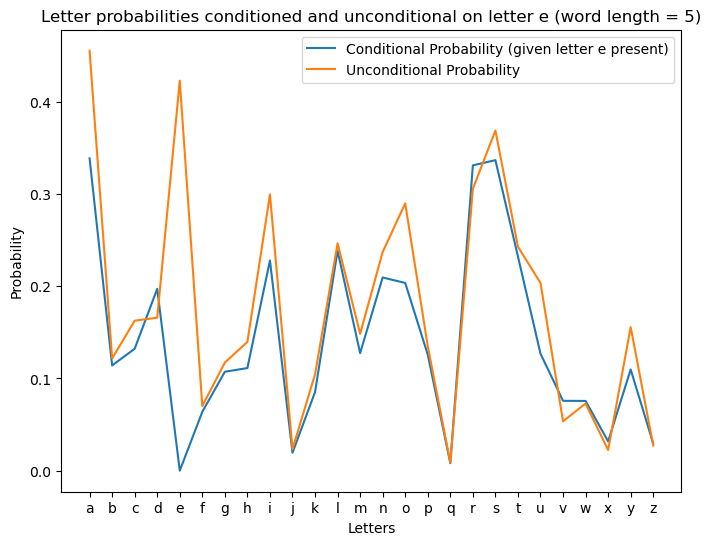

In [10]:
# Plot your data
plt.figure(figsize = (8,6))
plt.plot(range(26), conditional_prob, label = 'Conditional Probability (given letter e present)')
plt.plot(range(26), un_conditional_prob, label = 'Unconditional Probability')

# Set x-axis labels as 'a' to 'z'
plt.xticks(ticks=range(26), labels=list(string.ascii_lowercase))

# Optional: Add labels and legend for clarity
plt.xlabel('Letters')
plt.ylabel('Probability')
plt.legend()
plt.title('Letter probabilities conditioned and unconditional on letter e (word length = 5)')

plt.show()

The figure above shows how the probability of observing each letter changes when the letter 'e' is present in a word. Similarly, we can analyze how these probabilities shift when we know that 'e' is not present.

In [11]:
_, conditional_prob = prob_screening(guessed_wrong_letters = ['e'], guessed_correct_letters = [], word_length = 5)
_, un_conditional_prob = prob_screening(guessed_wrong_letters = [], guessed_correct_letters = [], word_length = 5)

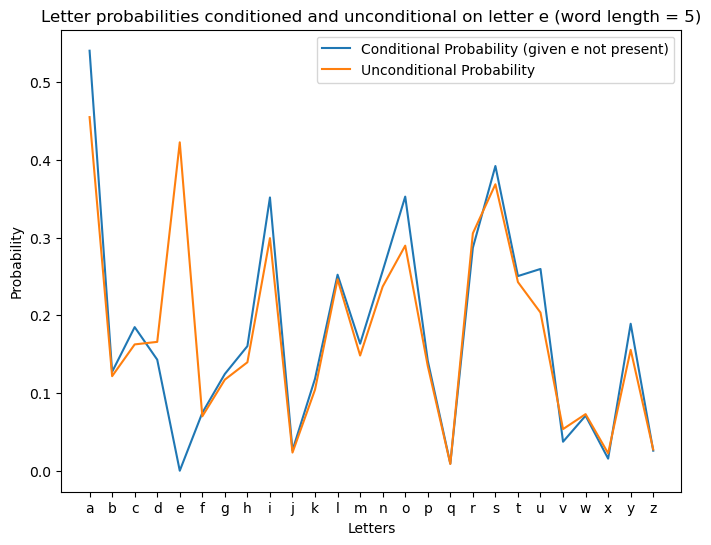

In [12]:
# Plot your data
plt.figure(figsize = (8,6))
plt.plot(range(26), conditional_prob, label = 'Conditional Probability (given e not present)')
plt.plot(range(26), un_conditional_prob, label = 'Unconditional Probability')

# Set x-axis labels as 'a' to 'z'
plt.xticks(ticks=range(26), labels=list(string.ascii_lowercase))

# Optional: Add labels and legend for clarity
plt.xlabel('Letters')
plt.ylabel('Probability')
plt.legend()
plt.title('Letter probabilities conditioned and unconditional on letter e (word length = 5)')

plt.show()

If we know the letter 'e' is not present in a word, the probability of observing each letter is different than knowing that the letter 'e' is present.
Take the letter 'i' as an example, the probability goes up when 'e' is not presented, but goes down when 'e' is presented.

We can always do more data analysis if we want, but the above analysis should give us a good understanding of the data. We can try to build our models now—and if needed, we can always return to explore the data further.

---

## 3. Prepare the Data: Encoding the Words

**To train our bidirectional LSTM model, we need to prepare features and labels. For example:**

* **Words:** `a p p _ e`, **Guessed letters (includes both correct and incorrect attempts):** `a, p, h, t` → **Target:** `l`
* **Words:** `o _ a n g _`  **Guessed letters (includes both correct and incorrect attempts):** `o, t, a, n, g, i` → **Target:** `r, e`

**The idea is to convert words into numerical sequences that the neural network can process.**

* **Words encoding:**
  Each word is encoded as a fixed-length sequence of 20 elements (since we ignore words longer than 20 letters).

  * Letters are mapped to numbers: `a` → 1, `b` → 2, ..., `z` → 26
  * Unknown letters (e.g., `_`) are represented as 27
  * Words shorter than 20 are padded with 0.
  * Example: `a p p _ e` → [1, 14, 14, 27, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

* **Target and guessed letters encoding:**
  The target and the guessed letters are represented as a 26-dimensional one-hot vector, where each index corresponds to a letter `a`–`z`.

  * If a letter is part of the target, its corresponding entry is 1; otherwise, it's 0.
  * For cases where multiple correct letters are possible (like `r` and `e`), the vector will have multiple 1s.
  * Example: `r, e` → [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]

### Training Data Generation Strategy

**There are many possible approaches to generating training samples for our model.**
One exhaustive method would be to generate **all possible masked versions** of each word. For a word of length *L*, this would include:

* Masking each individual letter (one at a time)
* Masking all possible pairs of letters
* Continuing up to fully masking the word

**While this method is comprehensive, it’s also computationally expensive**, potentially creating far more samples than the model needs or can efficiently handle. If computational resources were unlimited, this brute-force strategy might be viable and could potentially word well. But my aproach is to selectively generate training samples.

---

### **Selective Sampling Strategy**

To balance efficiency and effectiveness, we use the following principles to guide training sample selection:

1. All words have at least two letters revealed. This is because, at the start of the game, we only know the word length. The optimal strategy is to first guess the letters that have the highest probability of appearing, given that length. Therefore, we do not want our model to handle the early stages of the game—there’s little benefit in using a deep learning model here, as a statistical approach is more efficient and effective. When one letter is revealed, or one attempt is failed, we use the conditional probability of each letter appearing.

2. We use more samples where additional letters are already revealed. The intuition is that the model should learn from more informative representations. As we’ll see, the most challenging part of the game is often guessing the last one or two letters.

3. The distribution of word lengths in the training samples should remain relatively consistent. If train_words consists mostly of words with lengths between 5 and 15, then the model should be exposed to a similar distribution during training to ensure proper generalization.

---

This targeted sampling strategy ensures that the model is trained efficiently on the most useful and realistic examples it will encounter during actual gameplay.


In [13]:
def make_masked_word(word, guessed):
    return ''.join([c if c in guessed else '_' for c in word])

In [14]:
idx_to_letter = {idx:letter for idx, letter in enumerate(alphabet)}

In [15]:
def naive_method(word):
    wrong_guess = []
    correct_guess = []
    n = len(word)
    word_set = set(word)
    if len(word_set) <= 2:
        return [], list(word_set), []

    while len(correct_guess) < 2:
        #_, prob = prob_screening(wrong_guess, correct_guess, n)
        #predict = idx_to_letter[np.argmax(prob)]
        prob = distribution[n-1]
        prob = np.argsort(prob)[::-1]
        for i in prob:
            predict = idx_to_letter[i]
            if predict in wrong_guess or predict in correct_guess:
                continue
            else:
                # not guessed before
                if predict in word_set:
                    correct_guess.append(predict)
                    word_set.remove(predict)
                else:
                    wrong_guess.append(predict)
                break

    return list(word_set), correct_guess, wrong_guess

In [16]:
def create_training_examples(word):
    # generate training samples for a given word
    # print(word)
    if len(set(word)) <= 2:
        return []
    examples = []
    # filter out two letters using the naive method
    unique_letters, correct_letters, _ = naive_method(word)
    n = len(unique_letters)
    if n == 0:
        return []
    
    for k in range(n):
        # k: number of guessed letters
        combinations_list = [list(x) for x in combinations(unique_letters, k)]
        # up-sample training samples with larger k: number of guessed letters
        # intuition: it is easier to start guessing but it is harder to guess the last one or two letters
        #if len(combinations_list) < 2*k:
        #    size = len(combinations_list)
        #else:
        #    size = 2*k
        size = k
        #if k == n-2:
        #    size = 2*k # more samples for 2 targets?

        selected_index = np.random.choice([i for i in range(len(combinations_list))], size=size, replace=False)
        
        selected_list = [combinations_list[i] for i in selected_index]
        
        for comb in selected_list:
            #print(comb)
            masked = make_masked_word(word, comb + correct_letters)
            remaining_letters = [c for c in unique_letters if c not in comb]
            #guessed = [chr(c) for c in range(ord('a'), ord('a') + 26) if c not in comb and c not in remaining_letters]
            #guessed_size = np.random.choice([i for i in range(6)], size = 1)
            #guessed = np.random.choice(guessed, size=guessed_size, replace=False)
            guessed = list(correct_letters) + list(comb)            
            examples.append({
                "masked_word": masked,
                "guessed_letters": ''.join(guessed),
                "target": ''.join(remaining_letters)  # multiple correct letters
            })

    return examples

In [17]:
def process_dictionary(word_list, output_file): 
    max_word_length = 20
    all_examples = [[] for _ in range(max_word_length)]
    num_examples = [0]*max_word_length
    i = 0
    num_samples = 0
    for word in word_list:
        n = len(word)
        if not word.isalpha() or n > max_word_length:
            # skip word longer than max_word_length
            continue
        word = word.lower().strip()
        examples = create_training_examples(word)
        if examples != []:
            num_samples += len(examples)
            all_examples[n-1].extend(examples)
        i += 1

    # re-distribute training samples: so that the proportion of 
    # given length of words in trainin data would be equal to that of the whole data
    probabilities = word_length_count[:max_word_length]/np.sum(word_length_count[:max_word_length])
    samples_per_length = np.int32(num_samples * probabilities)
    for i in range(len(all_examples)):
        if len(all_examples[i]) > samples_per_length[i]:
            all_examples[i] = np.random.choice(all_examples[i], size=samples_per_length[i], replace=False)
        num_examples[i] = len(all_examples[i])
        
    # merge all_examples
    merged_list = []
    for sublist in all_examples:
        for item in sublist:
            merged_list.append(item)

    with open(output_file, 'w') as f:
        # write each example as a separate line in the JSONL file
        for ex in merged_list:
            f.write(json.dumps(ex) + "\n")

    print(f"Generated {len(merged_list)} training samples.")

    return merged_list, num_examples

In [18]:
len(train_words)

295721

In [19]:
training_data, num_examples = process_dictionary(train_words, './Data/training_data.jsonl')

Generated 3147375 training samples.


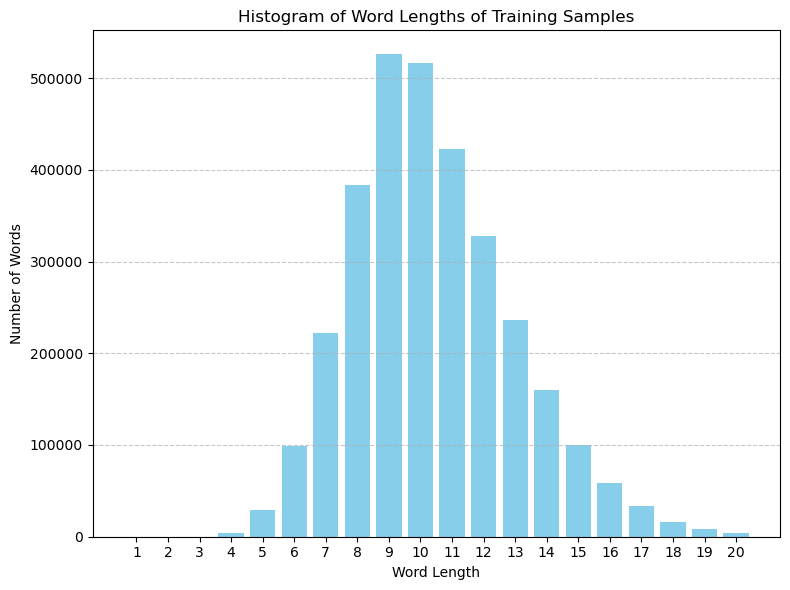

In [20]:
max_word_length = 20
num_examples = np.array(num_examples)
x = list(range(1, max_word_length+1))
plt.figure(figsize=(8, 6))
plt.bar(x, num_examples.reshape(-1), color='skyblue')
plt.xlabel("Word Length")
plt.ylabel("Number of Words")
plt.title("Histogram of Word Lengths of Training Samples")
plt.xticks(x)  # Ensure each word length shows up on the x-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [21]:
random.shuffle(training_data)

In [22]:
training_data

[{'masked_word': 'pa_ronizes', 'guessed_letters': 'eipaosrnz', 'target': 't'},
 {'masked_word': 'mor_hologies',
  'guessed_letters': 'ieohgsrlm',
  'target': 'p'},
 {'masked_word': 'in__gitan_y', 'guessed_letters': 'iagtyn', 'target': 'oc'},
 {'masked_word': 'p_pil_onger', 'guessed_letters': 'eipogrln', 'target': 'mu'},
 {'masked_word': '_astru_ate', 'guessed_letters': 'eatsru', 'target': 'gl'},
 {'masked_word': '_i_c_o_e', 'guessed_letters': 'eioc', 'target': 'hsm'},
 {'masked_word': 'pre__il', 'guessed_letters': 'eiprl', 'target': 'oc'},
 {'masked_word': '_apiases', 'guessed_letters': 'eapsi', 'target': 'c'},
 {'masked_word': 'i__e__b_a_c_ia_e',
  'guessed_letters': 'ieacb',
  'target': 'ohtfrn'},
 {'masked_word': 'b_llne__', 'guessed_letters': 'enlb', 'target': 'cku'},
 {'masked_word': 'millefle__', 'guessed_letters': 'eiflm', 'target': 'ru'},
 {'masked_word': 'tr___ed', 'guessed_letters': 'ertd', 'target': 'ol'},
 {'masked_word': 'u_brellawise',
  'guessed_letters': 'ieasrwlbu',
  

c:\Users\yijin\anaconda3\envs\tf-gpu\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'number of training samples')

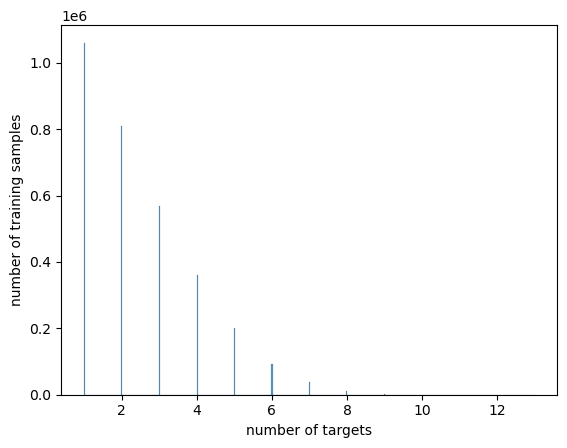

In [23]:
sns.histplot([len(training_data[i]['target']) for i in range(len(training_data))])
plt.xlabel('number of targets')
plt.ylabel('number of training samples')

In [24]:
# build vocabulary ordinal encoding
vocab = ['Pad'] + list(chr(i) for i in range(ord('a'), ord('z')+1)) + ['_']
char2idx = {ch: i for i, ch in enumerate(vocab)}

In [25]:
# encoding functions
def encode_input(masked_word, max_len=20):
    input_str = masked_word
    input_ids = [char2idx[c] for c in input_str]
    if len(input_ids) < max_len:
        input_ids += [char2idx['Pad']] * (max_len - len(input_ids))
    return input_ids

In [26]:
def encode_target(target):
    target_vec = [0] * 26  # only 'a' to 'z'
    for c in target:
        target_vec[ord(c) - ord('a')] = 1
    return target_vec

In [27]:
def encode(masked_word, guessed_letters, target, max_len=20):
    input_ids = encode_input(masked_word, max_len)
    guessed_vec = encode_target(guessed_letters)
    target_vec = encode_target(target)
    return input_ids, guessed_vec, target_vec

In [28]:
def encode_jsonl_data(input_path, output_path, max_len=20):
    encoded_data = []
    with open(input_path, "r") as f:
        for line in f:
            item = json.loads(line)
            masked_word = item["masked_word"]
            guessed_letters = item["guessed_letters"]
            target = item["target"]
            input_ids, guessed_vec, target_vec = encode(
                masked_word, guessed_letters, target, max_len
            )
            encoded_data.append({
                "input_ids": input_ids,
                "guessed_letters": guessed_vec,
                "target_vec": target_vec
            })
    # save encoded data
    with open(output_path, 'w') as f:
        # write each example as a separate line in the JSONL file
        for ex in encoded_data:
            f.write(json.dumps(ex) + "\n")
    
    print(f"Encoded {len(encoded_data)} samples.")
    return encoded_data


In [29]:
output_path = "./Data/encoded_training_data.jsonl"
input_path = "./Data/training_data.jsonl"
training_data = encode_jsonl_data(input_path, output_path, max_len=20)

Encoded 3147375 samples.


In [30]:
len(training_data)

3147375

In [31]:
training_data_input_ids = []
training_data_guessed_letters = []
training_data_targets = []
for i in range(len(training_data)): 
    training_data_input_ids.append(training_data[i]['input_ids'])
    training_data_guessed_letters.append(training_data[i]['guessed_letters'])
    training_data_targets.append(training_data[i]['target_vec'])

In [32]:
training_data_input_ids = np.array(training_data_input_ids)
training_data_guessed_letters =  np.array(training_data_guessed_letters)
training_data_targets = np.array(training_data_targets)

In [33]:
training_data_length = np.sum(training_data_input_ids != 0, axis=1)/20

In [34]:
print(training_data_input_ids.shape)
print(training_data_guessed_letters.shape)
print(training_data_length.shape)
print(training_data_targets.shape)

(3147375, 20)
(3147375, 26)
(3147375,)
(3147375, 26)


## **Train Bidirectional LSTM models**: Model size is the key

We are ready to train our models using the prepared data. In this task, we demonstrate that model size plays a crucial role in performance.

In [35]:
def build_hangman_lstm_model(
    embedding_dim=128,
    sequence_len=20,
    lstm_units=[512, 256, 128],
    dense_units=64,
    learning_rate=3e-3
):
    seq_input = Input(shape=(sequence_len,), name="seq_input")
    embedding = Embedding(input_dim=28, output_dim=embedding_dim, mask_zero=True)(seq_input)

    x = embedding
    for i, units in enumerate(lstm_units):
        return_seq = i < len(lstm_units) - 1
        x = Bidirectional(LSTM(units, return_sequences=return_seq))(x)

    binary_input = Input(shape=(26,), name="binary_input")
    combined = Concatenate()([x, binary_input])
    combined = Dense(dense_units, activation='relu')(combined)
    output = Dense(26, activation="sigmoid", name="output")(combined)

    model = Model(inputs=[seq_input, binary_input], outputs=output)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="binary_crossentropy")
    return model

In [36]:
# Add EarlyStopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [37]:
class CustomDataGenerator(Sequence):
    def __init__(self, input_data_ids, input_data_binary, target_data, batch_size, shuffle=True):
        self.input_data_ids = input_data_ids
        self.input_data_binary = input_data_binary
        self.target_data = target_data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.input_data_ids))  # Indices to shuffle the data
        self.on_epoch_end()  # Shuffle data at the beginning

    def __len__(self):
        # Returns the number of batches per epoch
        return int(np.floor(len(self.input_data_ids) / self.batch_size))

    def __getitem__(self, index):
        # Generate one batch of data
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_input_ids = [self.input_data_ids[i] for i in batch_indices]
        batch_input_data_binary = [self.input_data_binary[i] for i in batch_indices]
        batch_target = [self.target_data[i] for i in batch_indices]

        return (np.array(batch_input_ids), np.array(batch_input_data_binary)), np.array(batch_target)

    def on_epoch_end(self):
        # Shuffle data at the end of each epoch
        if self.shuffle:
            np.random.shuffle(self.indices)

In [38]:
# Set batch size and training parameters
batch_size = 1024

# Split data into training and validation sets
split_idx = int(0.9 * len(training_data_input_ids))  # 90% for training
train_input_ids = training_data_input_ids[:split_idx]
train_input_data_binary = training_data_guessed_letters[:split_idx]
train_target = training_data_targets[:split_idx]

val_input_ids = training_data_input_ids[split_idx:]
val_input_data_binary = training_data_guessed_letters[split_idx:]
val_target = training_data_targets[split_idx:]

In [39]:
len(train_input_ids)

2832637

In [40]:
# Create the training and validation generators
train_gen = CustomDataGenerator(train_input_ids, train_input_data_binary, train_target, batch_size)
val_gen = CustomDataGenerator(val_input_ids, val_input_data_binary, val_target, batch_size)

In [42]:
lstm_model_small = build_hangman_lstm_model(
    embedding_dim=32,
    sequence_len=20,
    lstm_units=[64, 32, 32],
    dense_units=32,
    learning_rate=3e-3)

In [43]:
lstm_model_small.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 seq_input (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 20, 32)       896         ['seq_input[0][0]']              
                                                                                                  
 bidirectional (Bidirectional)  (None, 20, 128)      49664       ['embedding[0][0]']              
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 20, 64)      41216       ['bidirectional[0][0]']          
 )                                                                                            

In [44]:
lstm_model_median = build_hangman_lstm_model(
    embedding_dim=64,
    sequence_len=20,
    lstm_units=[256, 128, 64],
    dense_units=32,
    learning_rate=3e-3)

In [45]:
lstm_model_median.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 seq_input (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 20, 64)       1792        ['seq_input[0][0]']              
                                                                                                  
 bidirectional_3 (Bidirectional  (None, 20, 512)     657408      ['embedding_1[0][0]']            
 )                                                                                                
                                                                                                  
 bidirectional_4 (Bidirectional  (None, 20, 256)     656384      ['bidirectional_3[0][0]']  

In [46]:
lstm_model_large = build_hangman_lstm_model(
    embedding_dim=64,
    sequence_len=20,
    lstm_units=[512, 512, 512, 128, 64],
    dense_units=32,
    learning_rate=3e-3)

In [47]:
lstm_model_large.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 seq_input (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 20, 64)       1792        ['seq_input[0][0]']              
                                                                                                  
 bidirectional_6 (Bidirectional  (None, 20, 1024)    2363392     ['embedding_2[0][0]']            
 )                                                                                                
                                                                                                  
 bidirectional_7 (Bidirectional  (None, 20, 1024)    6295552     ['bidirectional_6[0][0]']  

In [185]:
# Set batch size and training parameters
epochs = 50
# Train the model using the generators
history = lstm_model_small.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=[early_stop]
)

Epoch 1/50
2766/2766 [==============================] - 118s 36ms/step - loss: 0.2099 - val_loss: 0.2168
Epoch 2/50
2766/2766 [==============================] - 94s 34ms/step - loss: 0.1733 - val_loss: 0.2078
Epoch 3/50
2766/2766 [==============================] - 112s 41ms/step - loss: 0.1648 - val_loss: 0.2054
Epoch 4/50
2766/2766 [==============================] - 124s 45ms/step - loss: 0.1600 - val_loss: 0.2066
Epoch 5/50
2766/2766 [==============================] - 95s 34ms/step - loss: 0.1572 - val_loss: 0.2078
Epoch 6/50
2766/2766 [==============================] - 94s 34ms/step - loss: 0.1552 - val_loss: 0.2104
Epoch 7/50
2766/2766 [==============================] - 97s 35ms/step - loss: 0.1536 - val_loss: 0.2109
Epoch 8/50
2766/2766 [==============================] - 95s 34ms/step - loss: 0.1521 - val_loss: 0.2100
Epoch 8: early stopping


Text(0.5, 1.0, 'Training and Validation Loss for smlall model')

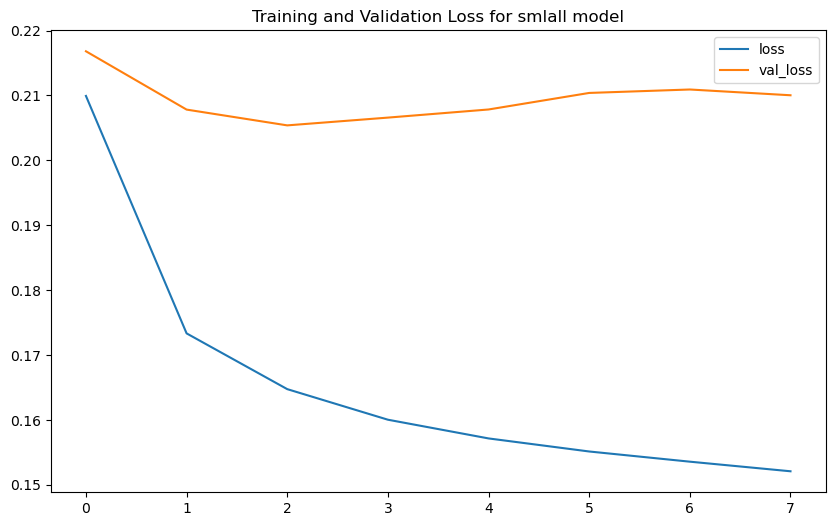

In [ ]:
pd.DataFrame(history.history).plot(figsize=(10, 6))
plt.title("Training and Validation Loss for small model")

In [192]:
lstm_model_small.save("./Models/lstm_model_small.keras")

In [193]:
# Set batch size and training parameters
epochs = 50
# Train the model using the generators
history = lstm_model_median.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=[early_stop]
)

Epoch 1/50
2766/2766 [==============================] - 137s 45ms/step - loss: 0.2014 - val_loss: 0.2021
Epoch 2/50
2766/2766 [==============================] - 134s 48ms/step - loss: 0.1536 - val_loss: 0.1832
Epoch 3/50
2766/2766 [==============================] - 138s 50ms/step - loss: 0.1391 - val_loss: 0.1790
Epoch 4/50
2766/2766 [==============================] - 138s 50ms/step - loss: 0.1313 - val_loss: 0.1806
Epoch 5/50
2766/2766 [==============================] - 132s 48ms/step - loss: 0.1262 - val_loss: 0.1801
Epoch 6/50
2766/2766 [==============================] - 119s 43ms/step - loss: 0.1225 - val_loss: 0.1844
Epoch 7/50
2766/2766 [==============================] - 123s 44ms/step - loss: 0.1196 - val_loss: 0.1845
Epoch 8/50
2766/2766 [==============================] - 129s 47ms/step - loss: 0.1174 - val_loss: 0.1872
Epoch 8: early stopping


Text(0.5, 1.0, 'Training and Validation Loss for median model')

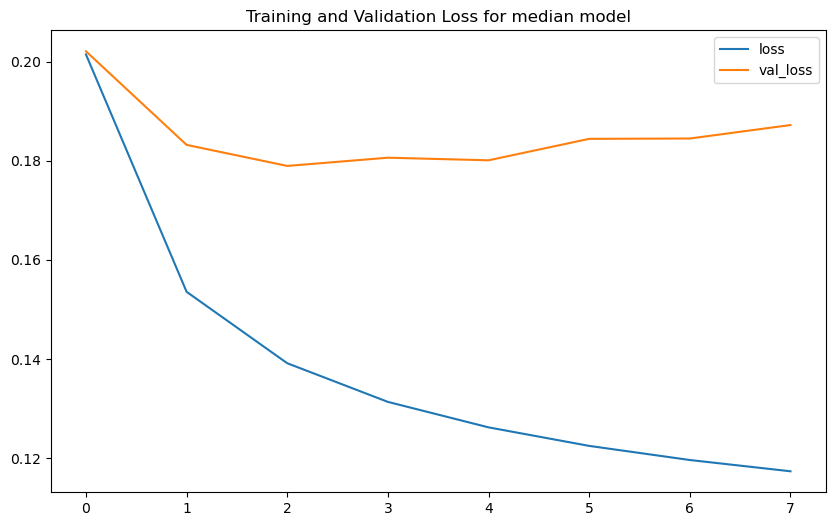

In [194]:
pd.DataFrame(history.history).plot(figsize=(10, 6))
plt.title("Training and Validation Loss for median model")

In [195]:
lstm_model_median.save("./Models/lstm_model_median.keras")

In [196]:
# Set batch size and training parameters
epochs = 50
# Train the model using the generators
history = lstm_model_large.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=[early_stop]
)

Epoch 1/50
2766/2766 [==============================] - 434s 144ms/step - loss: 0.2029 - val_loss: 0.1889
Epoch 2/50
2766/2766 [==============================] - 393s 142ms/step - loss: 0.1454 - val_loss: 0.1623
Epoch 3/50
2766/2766 [==============================] - 392s 142ms/step - loss: 0.1264 - val_loss: 0.1587
Epoch 4/50
2766/2766 [==============================] - 399s 144ms/step - loss: 0.1149 - val_loss: 0.1621
Epoch 5/50
2766/2766 [==============================] - 397s 144ms/step - loss: 0.1071 - val_loss: 0.1658
Epoch 6/50
2766/2766 [==============================] - 403s 146ms/step - loss: 0.1007 - val_loss: 0.1653
Epoch 7/50
2766/2766 [==============================] - 399s 144ms/step - loss: 0.0950 - val_loss: 0.1717
Epoch 8/50
2766/2766 [==============================] - 404s 146ms/step - loss: 0.0900 - val_loss: 0.1718
Epoch 8: early stopping


In [197]:
lstm_model_large.save("./Models/lstm_model_large.keras")

Text(0.5, 1.0, 'Training and Validation Loss for large model')

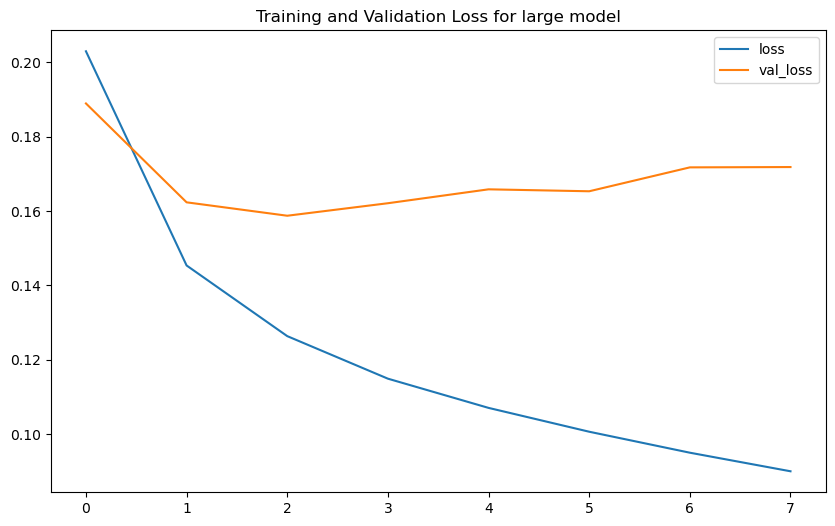

In [198]:
pd.DataFrame(history.history).plot(figsize=(10, 6))
plt.title("Training and Validation Loss for large model")

---

## 5. Develop the Strategy: Leveraging Statistical Approach and the Bidirectional LSTM

Our strategy combines the strengths of both statistical analysis and deep learning through a three-stage adaptive approach:

**Early Stage (0-1 letters known)**
The game begins in the early stage when fewer than two letters are revealed. At this point, word patterns are unclear and insufficient for meaningful pattern recognition. Perphas the optimal strategy is to rely on pure statistical frequency analysis:
- First letter: Choose the letter with highest frequency in the dictionary given the word length.
- Second letter: Choose based on highest frequency considering the first letter, word length, and previous wrong attempts.

**Mid Stage (2+ letters known, abundant candidate words)**
The game moves to mid stage when at least two letters are known. Pure frequency-based guessing could becomes suboptimal in this stage because it ignores letter positioning. At this stage, we employ a hybrid approach:
- Combine statistical frequency predictions with LSTM model outputs.

**Late Stage (Sparse candidate words or critical decisions)**
The late stage of the game is triggered when either:
- Fewer than 200 words in the dictionary satisfy current constraints, i.e. word length, correct attempts, and wrong attemps. Or
- only 3 attempts remain.

The word candidate pool becomes spars. Hence it is unreliable, in particular the testing words is disjoiint with the words dictionary. However, at this stage, the word patterns become highly informative (e.g., "a _ _ l e"). At this stage, we rely exclusively on the LSTM model for pattern completion.

In [126]:
class HangmanGame:
    def __init__(self, model, word_list, max_len):
        # model: the model playing the game
        # word_list: training data set
        # max_len:  maximum allowable word length
        self.model = model
        self.word_list = word_list
        self.max_len = max_len
        self.vocab = ['Pad'] + list(alphabet) + ['_']
        self.char2idx = char2idx
        self.letter_to_idx = letter_to_idx
        self.guessed_letters = []

    def encode_word(self, masked_word):
        # ordinal encoder of masked word
        input_str = masked_word
        input_ids = [self.char2idx[c] for c in input_str]
        # pad if shorter than max_len: make sure fixed length sequence
        if len(input_ids) < self.max_len:
            input_ids += [self.char2idx['Pad']] * (self.max_len - len(input_ids))
        else:
            # trancate if longer than max length
            input_ids = input_ids[:self.max_len]

        return input_ids

    def encode_guessed_letters(self, guessed_letters):
        target_vec = [0] * 26  # only 'a' to 'z'
        for c in guessed_letters:
            target_vec[ord(c) - ord('a')] = 1
            
        return target_vec
    
    def encode_data(self, masked_word, guessed_letters):
        input_words = self.encode_word(masked_word)
        guessed_letters = self.encode_guessed_letters(guessed_letters)
        return input_words, guessed_letters
    
    # probability of words after screening out 
    def prob_screening(self, guessed_wrong_letters, guessed_correct_letters, word_length):
        guessed_wrong_set = set(guessed_wrong_letters)
        guessed_correct_letters = set(guessed_correct_letters)
        # Filter words
        possible_words = [
            word for word in self.word_list
            if len(word) == word_length and guessed_wrong_set.isdisjoint(word) and guessed_correct_letters.issubset(word)
            #if guessed_wrong_set.isdisjoint(word) and guessed_correct_letters.issubset(word)
        ]
        # Initialize probability array
        prob = [0] * 26
        for word in possible_words:
            for letter in set(word):  # avoid double-counting letters
                prob[self.letter_to_idx[letter]] += 1
        n = max(len(possible_words), 1)  # avoid division by zero
        prob = [p/n for p in prob]
        return len(possible_words), np.array(prob)

    def guess(self, word, tries_remains): # word input example: "_ p p _ e "
        ###############################################
        ################# Guess strategy ##############
        ###############################################
        # remove space and make sure lower cases
        word = word.replace(" ", "").lower()
        # if letters in word, then put them in guesses_letters as well
        correct_letters = list(set(word))
        correct_letters.remove('_')
        guessed_letters = self.guessed_letters + [letters for letters in word if letters != '_' and letters not in self.guessed_letters]
        wrong_letters = [c for c in guessed_letters if c not in correct_letters]
        word_len = len(word)
        if word_len > self.max_len:
            word_len = self.max_len

        #unknown_number = word.count('_')
        #unknown_ratio = unknown_number / word_len
        #print('correct_letters:', correct_letters)
        #print('wrong_letters:', wrong_letters)
        #print('guessed_letters:', guessed_letters)
        
        known_number = len(set(word)) - 1  # minus '_'
        if known_number < 3 or tries_remains > 4:
            #print('Early Stage of the game')
            # start stage: strategic rules for the first two letters
            _, prob_vector = self.prob_screening(wrong_letters, correct_letters, word_len)  # shape (26,)
            # sort letters by descending probability
            sorted_indices = np.argsort(prob_vector)[::-1]
            for idx in sorted_indices:
                if chr(ord('a') + idx) not in guessed_letters: 
                    return chr(ord('a') + idx)
        else:
            # enter the mid and late stage of the game
            len_dict, uncon_prob = self.prob_screening(wrong_letters, correct_letters, word_len)          
            # encode data
            word, guessed_letters = self.encode_data(word, guessed_letters)
            word = np.array(word).reshape(1,-1)
            guessed_letters = np.array(guessed_letters).reshape(1,-1)
            probs = self.model.predict([word, guessed_letters], verbose=0)  # shape (26,)
            if len_dict > 200 and tries_remains > 2:
                #print('Mid Stage of the game')
                # mid stage of the game: model prediction combines with the strategic rules 
                probs = uncon_prob*probs
                #print('Late Stage of the game')

            # else: late stage of the game
            # convert guessed letters from binary to a boolean mask
            guessed_mask = np.array(guessed_letters).astype(bool)
            # set the probabilities of already guessed letters to -1 to ignore them
            probs[guessed_mask] = -1
            # pick the index (letter) with the highest remaining probability
            next_letter_index_probs = np.argmax(probs)
            next_letter = string.ascii_lowercase[next_letter_index_probs]

            return next_letter

    def play(self, test_word, max_wrong=6, verbose=True):
        word = test_word.lower()
        display = ['_' for _ in word]
        self.guessed_letters = []
        wrong_guesses = 0
        tries_remain = max_wrong
        if verbose:
            print(f"Word: {' '.join(display)}")
        while wrong_guesses < max_wrong and '_' in display:
            masked_word = ''.join(display)
            guess_letter = self.guess(masked_word, tries_remain)
            self.guessed_letters.append(guess_letter)
            if guess_letter in word:
                for i, c in enumerate(word):
                    if c == guess_letter:
                        display[i] = guess_letter
                if verbose:
                    print(f"Correct! {guess_letter}")
            else:
                wrong_guesses += 1
                tries_remain -= 1
                if verbose:
                    print(f"Wrong! {guess_letter}. {tries_remain} guesses left.")
            if verbose:
                print(' '.join(display))
        success = '_' not in display
        if verbose:
            if success:
                print(f"Win! The word was: {word}")
            else:
                print(f"Lose! The word was: {word}")
        return success

---

## 6. Playing the Game: Results and Further Improvements

Now we evaluate our trained models and strategy by simulating thousands of hangman games.

In [128]:
# read the three models trained above
lstm_model_small = load_model('./Models/lstm_model_small.keras')
lstm_model_median = load_model('./Models/lstm_model_median.keras')
lstm_model_large = load_model('./Models/lstm_model_large.keras')

In [129]:
def playHangmanGame(model, words, verbose = True):    
    game = HangmanGame(model, train_words, max_word_length)
    success_words = []
    fail_words = []
    for test_word in words:
        result = game.play(test_word, verbose=verbose)
        if result:
            success_words.append(test_word)
        else:
            fail_words.append(test_word)
    return success_words, fail_words

In [ ]:
models = [lstm_model_small, lstm_model_median, lstm_model_large]
success_words_all_models = []
fail_words_all_models = []
for model in models:
    # we play 1000 games for each model, this could take a while
    success_words, fail_words = playHangmanGame(model, test_words[:1000])
    success_words_all_models.append(success_words)
    fail_words_all_models.append(fail_words)

Word: _ _ _ _ _ _ _ _ _ _
Wrong! e. 5 guesses left.
_ _ _ _ _ _ _ _ _ _
Correct! i
_ _ _ _ _ _ _ _ i _
Correct! a
_ _ _ _ a _ _ _ i _
Wrong! n. 4 guesses left.
_ _ _ _ a _ _ _ i _
Wrong! r. 3 guesses left.
_ _ _ _ a _ _ _ i _
Wrong! l. 2 guesses left.
_ _ _ _ a _ _ _ i _
Correct! t
_ _ _ t a _ _ _ i _
Correct! o
_ _ _ t a _ o _ i _
Correct! s
_ _ s t a _ o _ i _
Correct! c
_ _ s t a _ o _ i c
Wrong! u. 1 guesses left.
_ _ s t a _ o _ i c
Correct! m
m _ s t a _ o _ i c
Correct! g
m _ s t a g o g i c
Correct! y
m y s t a g o g i c
Win! The word was: mystagogic
Word: _ _ _ _ _ _ _ _
Wrong! e. 5 guesses left.
_ _ _ _ _ _ _ _
Correct! i
_ _ _ _ _ _ i _
Correct! a
_ a _ a _ _ i a
Wrong! n. 4 guesses left.
_ a _ a _ _ i a
Wrong! s. 3 guesses left.
_ a _ a _ _ i a
Correct! r
_ a r a _ _ i a
Correct! t
_ a r a t t i a
Wrong! c. 2 guesses left.
_ a r a t t i a
Wrong! p. 1 guesses left.
_ a r a t t i a
Correct! m
m a r a t t i a
Win! The word was: marattia
Word: _ _ _ _
Wrong! a. 5 guesses left.


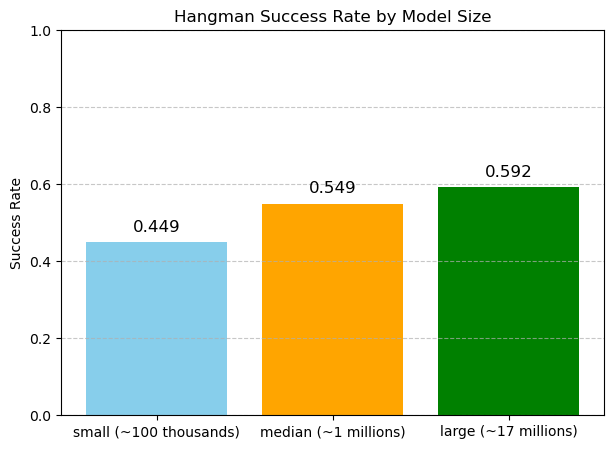

In [ ]:
model_names = ['small (~100 thousands)', 'median (~1 millions)', 'large (~17 millions)']
success_rates = [len(success_words_all_models[i])/1000 for i in range(3)] 
plt.figure(figsize=(7, 5))
bars = plt.bar(model_names, success_rates, color=['skyblue', 'orange', 'green'])
plt.ylabel('Success Rate')
plt.ylim(0, 1)
plt.title('Hangman Success Rate by Model Size')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of each bar
for bar, rate in zip(bars, success_rates):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02,
             f"{rate:.3f}", ha='center', va='bottom', fontsize=12)

plt.show()

In [ ]:
[word for word in fail_words_all_models[2] if len(word) > 18 ]

['interesterification', 'decentralizationist']

In [ ]:
length_longest_words = max([len(word) for word in test_words[:1000]])
count_word_length = [0] * length_longest_words
count_success_words_by_length = [0] * length_longest_words
for word in success_words_all_models[2]:
    count_success_words_by_length[len(word) - 1] += 1
    count_word_length[len(word) - 1] += 1

for word in fail_words_all_models[2]:
    count_word_length[len(word) - 1] += 1

In [ ]:
success_rates_by_length = [count_success_words_by_length[i] / count_word_length[i] for i in range(2,length_longest_words)]

In [ ]:
count_word_length

[0, 0, 5, 17, 44, 85, 116, 149, 147, 125, 97, 74, 56, 40, 16, 15, 4, 6, 4]

In [ ]:
count_success_words_by_length

[0, 0, 0, 4, 8, 21, 41, 79, 81, 90, 85, 61, 53, 36, 16, 8, 1, 6, 2]

c:\Users\yijin\anaconda3\envs\tf-gpu\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


Text(0.5, 1.0, 'successful rate of the algorithm across all word length')

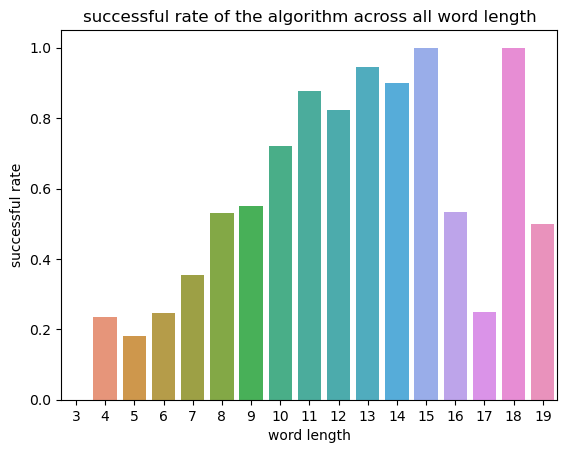

In [ ]:
sns.barplot(x = [i+1 for i in range(2,length_longest_words)], y = success_rates_by_length)
plt.xlabel('word length')
plt.ylabel('successful rate')
plt.title('successful rate of the algorithm across all word length')

## Conclusion
My strategy is to divide each Hangman game into three stages, early stage, mid stage, and late stage. The method of guessing the next letter gradually shifts from statistical frequency analysis to LSTM-based pattern recognition as more information becomes available.

### Stage Definitions and Strategies

**Early Stage (0-1 letters known or guess times > 4)**
The game begins in the early stage when fewer than two letters are revealed. At this point, word patterns are unclear and insufficient for meaningful pattern recognition. Perphas the optimal strategy is to rely on pure statistical frequency analysis:
- First letter: Choose the letter with highest frequency in the dictionary given the word length.
- Second letter: Choose based on highest frequency considering the first letter, word length, and previous wrong attempts.

**Mid Stage (2+ letters known, abundant candidate words)**
The game moves to mid stage when at least two letters are known. Pure frequency-based guessing could becomes suboptimal in this stage because it ignores letter positioning. At this stage, we employ a hybrid approach:
- Combine statistical frequency predictions with LSTM model outputs.

**Late Stage (Sparse candidate words or critical decisions)**
The late stage of the game is triggered when either:
- Fewer than 200 words in the dictionary satisfy current constraints, i.e. word length, correct attempts, and wrong attemps. Or
- only 2 attempts remain.

The word candidate pool becomes spars. Hence it is unreliable, in particular the testing words is disjoiint with the words dictionary. However, at this stage, the word patterns become highly informative (e.g., "a _ _ l e"). At this stage, we rely exclusively on the LSTM model for pattern completion.

### LSTM Training Strategy
Following our stragety for playing the game, the LSTM model is trained to be good at pattern recognition at late game rather than frequency guessing at early game:
- **Training data selection**: All samples contain at least two revealed letters.
- **Selective sampling**: Higher proportion of training examples with more letters revealed.

## Future Work
Our analysis reveals a clear relationship between word length and strategy performance. Our approach demonstrates significantly higher success rates for longer words, achieving approximately 60% success for 9-letter words, over 70% for 10-letter words, and exceeding 80% for words with 11+ letters. However, performance degrades substantially for shorter words, dropping below 40% for words with 7 or fewer letters.
This performance pattern suggests that our current strategy is optimized for scenarios where sufficient context information emerges during gameplay. Longer words provide more information for pattern recognition as the game progresses. However, shorter words offer limited information even in late stages.

Hence, the future work for improving the successful rate of the stragety is to focus on the shorter words. One possible solution is to train a new LSTM model focus solely on words with length smaller or equal to 8, potentially with different architectural choices optimized for limited context information scenarios. It is also possible to adaptively transit the stage of the game based on the word length: since the LSTM model appears to perform worse for shorter words, we might want to rely more on the statistical frequency analysis if the word length is short.

You may have noticed that our current strategy is to predict the conditional probability $$\text{Prob}(\text{next letter} \mid \text{masked word}).$$ A more accurate approach would be to model $$\text{Prob}(\text{next letter} \mid \text{masked word, guessed wrong letters}),$$ which incorporates the game's current state more completely. However, this would require a more sophisticated method for generating training data that reflects the true dynamics of the game. Simply adding random incorrect guesses could distort the model’s understanding and reduce its effectiveness. One interesting idea is to train two models that generate training data for each other. Another promising direction could be to apply reinforcement learning to learn an optimal guessing strategy directly from gameplay.